# King County Housing Analysis

---

**Import Necessary Libraries**

In [1]:
#data cleaning and stats
import pandas as pd
import numpy as np

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

#normality check
import scipy.stats as stats

#data transformation
from sklearn import preprocessing

#linear regression (sklearn and statsmodels)
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols

#model evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from math import sqrt
from functions import linreg_summary, ols_linreg_summary

---

## Data Understanding

In [2]:
df = pd.read_csv('data/kingcounty.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
#inspect data trypes and total value counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


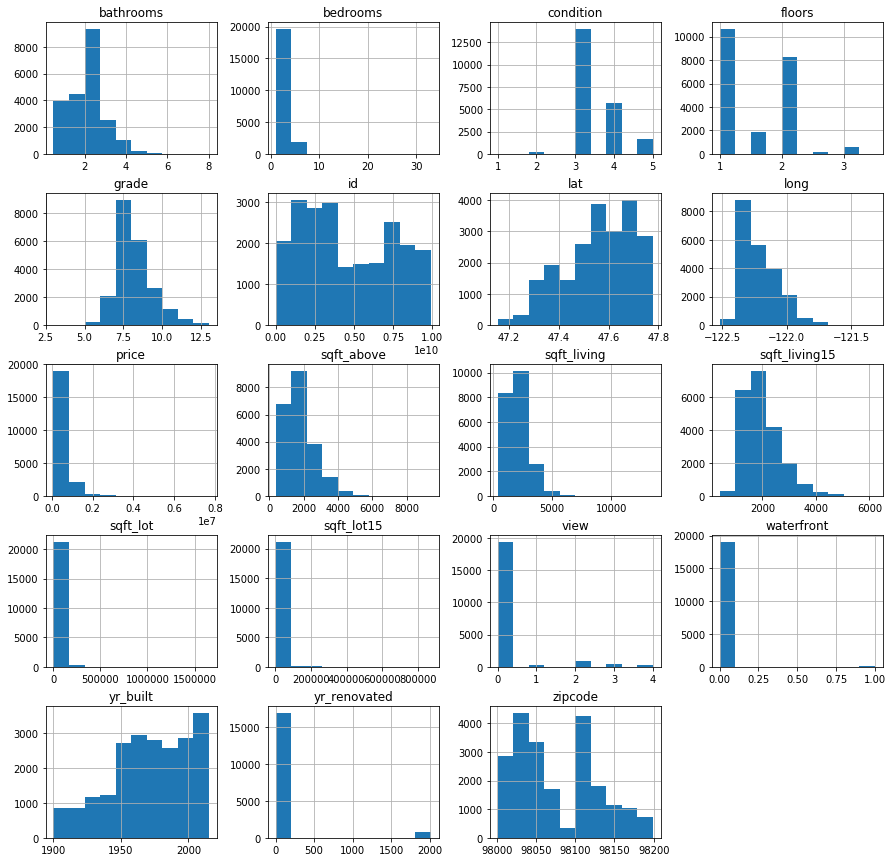

In [4]:
#distribution visualization
df.hist(figsize=(15,15));

In [5]:
#inspect for any columns with null values
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

**Initial data analysis:**
- 'waterfront', 'view', and 'yr_renovated' have null values
- 'yr_renovated' also has a significant amount of missing values represented with a placeholder value 0
- several variables have non-normal distributions, including target variable 'price'
- several variables are categorical variables
- variance in magnitudes of several variable values 

In [6]:
#display value count of placeholder value 
df['yr_renovated'].value_counts() 

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
2000.0       29
2005.0       29
1990.0       22
2004.0       22
2009.0       21
1989.0       20
2006.0       20
2002.0       17
1991.0       16
1998.0       16
1984.0       16
1999.0       15
2008.0       15
2010.0       15
2001.0       15
1983.0       15
2015.0       14
1985.0       14
1986.0       14
1987.0       14
1994.0       14
1992.0       13
1993.0       12
1997.0       12
1995.0       12
          ...  
1975.0        5
1964.0        5
1969.0        4
1963.0        4
1973.0        4
1981.0        4
1965.0        4
1978.0        3
1960.0        3
1958.0        3
1956.0        3
1955.0        3
1945.0        3
1972.0        3
1967.0        2
1957.0        2
1940.0        2
1974.0        2
1962.0        2
1953.0        1
1950.0        1
1934.0        1
1944.0        1
1976.0        1
1948.0        1
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Leng

In [7]:
#display percentage of column with null values
waterfront_perc_missing = round((df['waterfront'].isna().sum()/len(df['waterfront']))*100, 2)
view_perc_missing = round((df['view'].isna().sum()/len(df.view))*100, 2)
yr_renovated_perc_missing = round((df['yr_renovated'].isna().sum()/len(df['yr_renovated']))*100, 2)
yr_renovated_totalperc_missing = round(((df['yr_renovated'].isna().sum()+17011)/
                                        len(df['yr_renovated']))*100, 2)

print(f"'waterfront' null percentage: {waterfront_perc_missing}")
print(f"'view' null percentage: {view_perc_missing}")
print(f"'yr_renovated' null percentage: {yr_renovated_perc_missing}")
print(f"'yr_renovated' null + placeholder values: {yr_renovated_totalperc_missing}")

'waterfront' null percentage: 11.0
'view' null percentage: 0.29
'yr_renovated' null percentage: 17.79
'yr_renovated' null + placeholder values: 96.56


---

## Data Preparation

1. Drop 'yr_renovated' column because 96.56% of its data is missing.
2. Replace null values in 'waterfront' with the most common value since the value counts are significantly different.
3. Drop rows with missing values for 'view' column since it is only 0.29% of the dataset.
4. Conduct further data analysis.

In [8]:
df = df.drop('yr_renovated', axis=1)

# replace null values in "waterfront" with most common value 0
df['waterfront'] = df['waterfront'].fillna(0)

# drop null values in 'view' column
df = df.dropna(subset=['view'])

In [9]:
#sanity check
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 20 columns):
id               21534 non-null int64
date             21534 non-null object
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       21534 non-null float64
view             21534 non-null float64
condition        21534 non-null int64
grade            21534 non-null int64
sqft_above       21534 non-null int64
sqft_basement    21534 non-null object
yr_built         21534 non-null int64
zipcode          21534 non-null int64
lat              21534 non-null float64
long             21534 non-null float64
sqft_living15    21534 non-null int64
sqft_lot15       21534 non-null int64
dtypes: float64(7), int64(11), object(2)
memory usage: 3.5+ MB


---

**Further data inspection**

In [11]:
#after further inspection, I've discovered another placeholder value '?'
df['sqft_basement'].value_counts().head()

0.0      12798
?          452
600.0      216
500.0      209
700.0      207
Name: sqft_basement, dtype: int64

In [12]:
#replace '?' values with difference in sqft_living and sqft_above
df.loc[df['sqft_basement'] == '?', 'sqft_basement'] = df['sqft_living'] - df['sqft_above']

In [13]:
#change data type to float
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: float(x))

In [14]:
#drop 'id' column because it is not a predictor
#drop 'lat', 'long', and 'date' for now 
df = df.drop(df[['id', 'date', 'lat', 'long']], axis=1)

In [15]:
#change 'yr_built' column to 'age' of house column
df['age'] = df['yr_built'].apply(lambda x: 2019 - x)
df = df.drop(['yr_built'], axis=1)

**Transform categorical columns for use in Linear Regression model**

In [16]:
#transform categorical column 'waterfront'
waterfront_dummies = pd.get_dummies(df["waterfront"], 
                                    prefix="waterfront", 
                                    drop_first=True,
                                   dtype=int)
df = df.drop(["waterfront"], axis=1)
df = pd.concat([df, waterfront_dummies], axis=1)

---

### Correlation Visualization

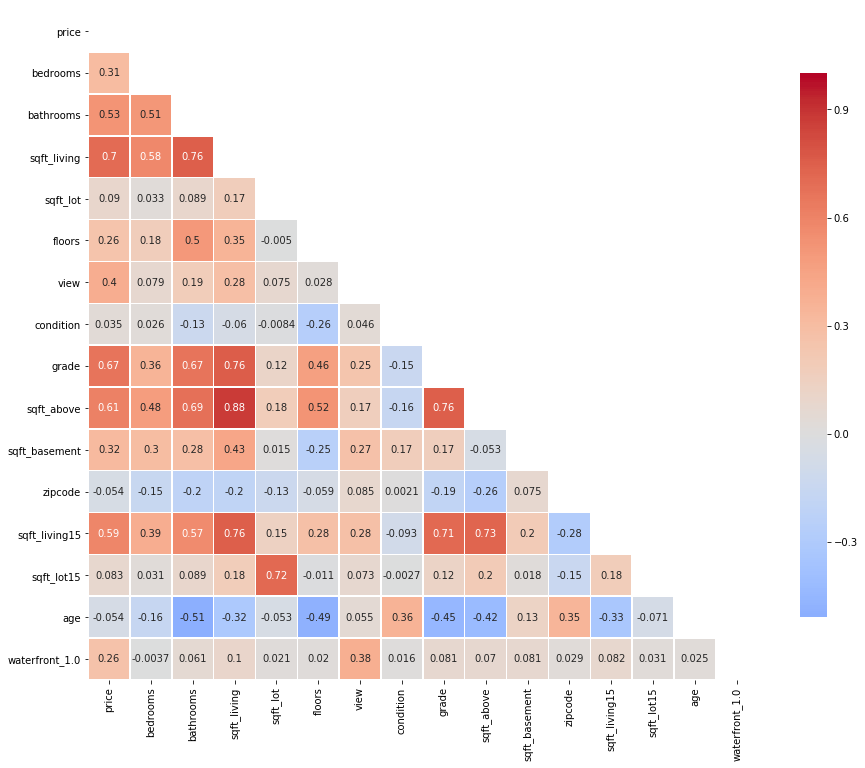

In [17]:
#visualize correlation using heatmap
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 20))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5});

**For my first model, I will start with variables that are positively correlated with the target variable.**

In [18]:
# create df for first model by dropping variables not positively correlated with 'price'
df_1 = df.drop(df[['zipcode', 'age']], axis=1)

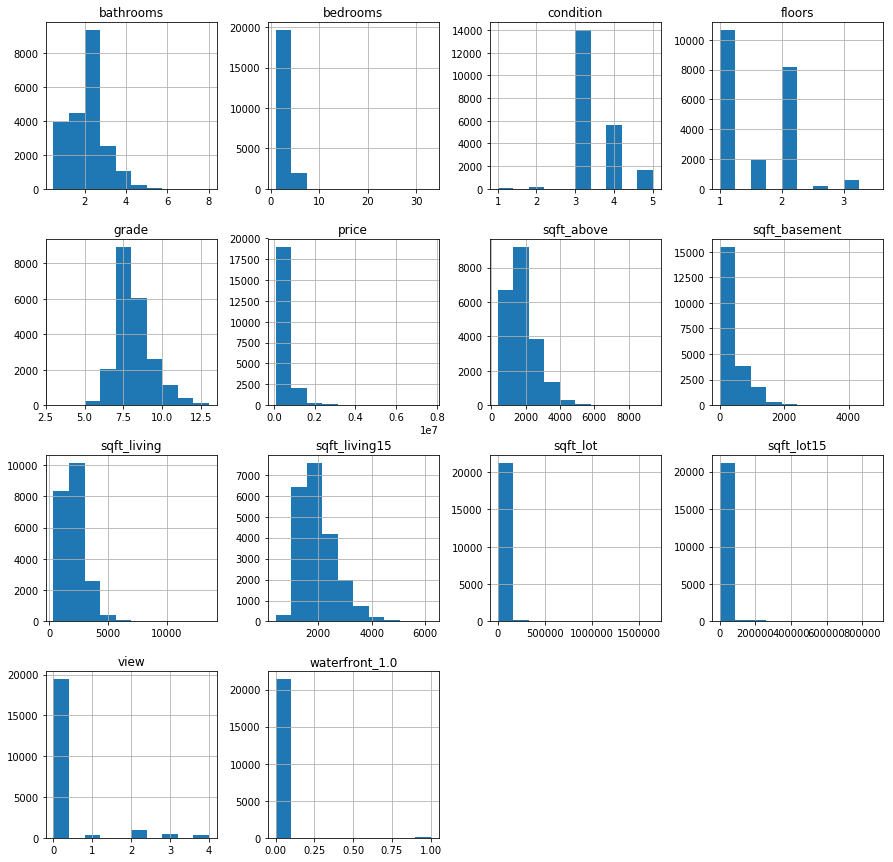

In [19]:
#let's take a look of distributions of selected predictors after preliminary data preparation
df_1.hist(figsize=(15,15));

---

## Linear Regression Assumption checks <br/>
1. Linearity 
2. Normality (residuals) - will check with residuals
3. Homoscedasticity

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


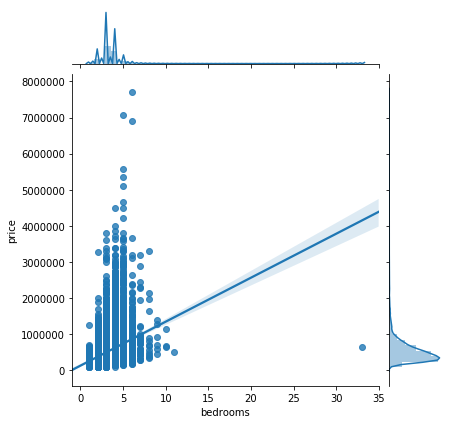

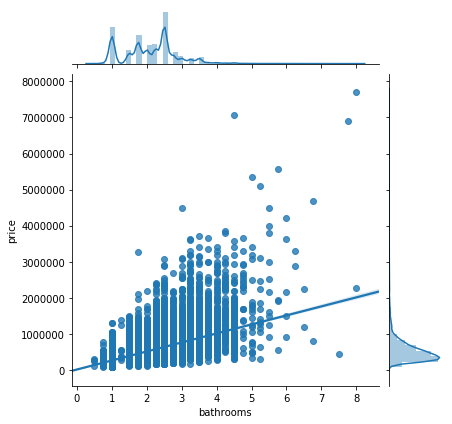

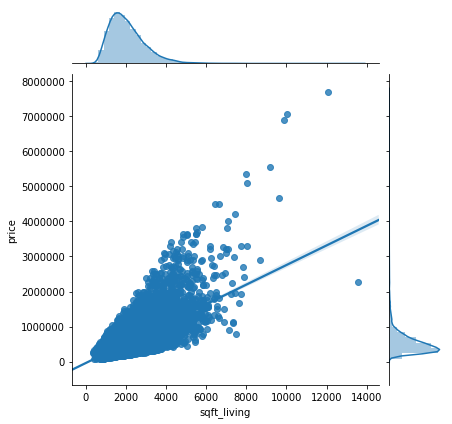

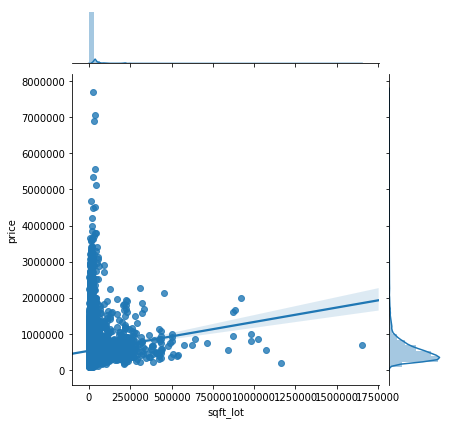

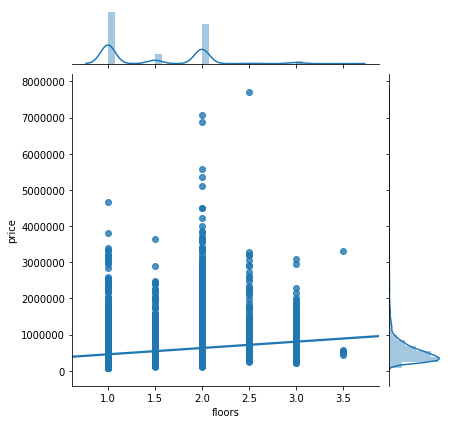

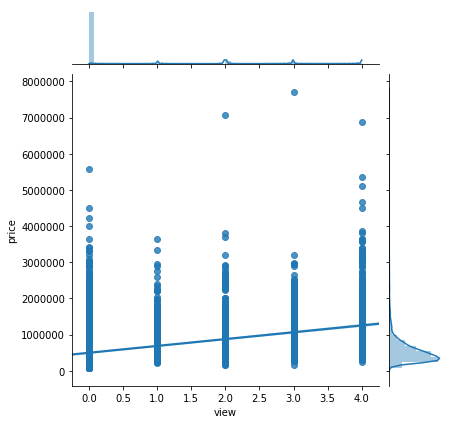

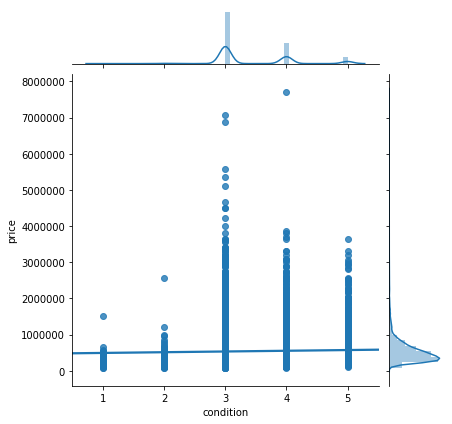

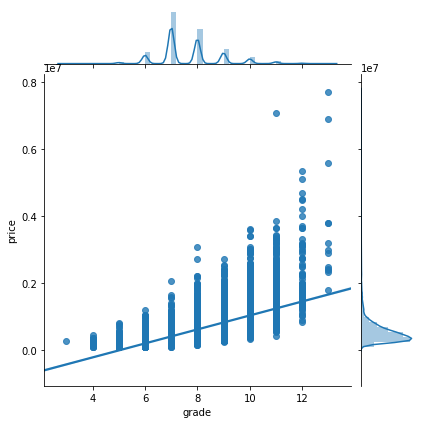

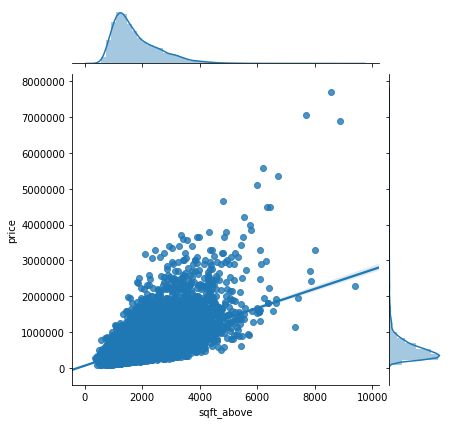

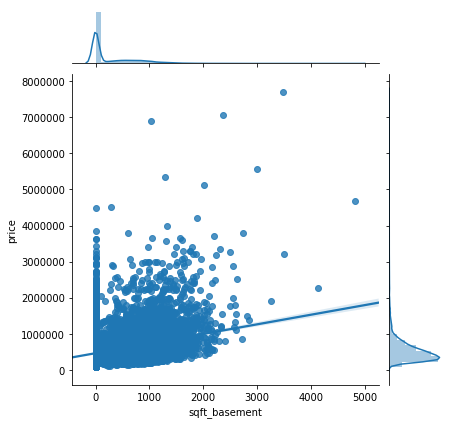

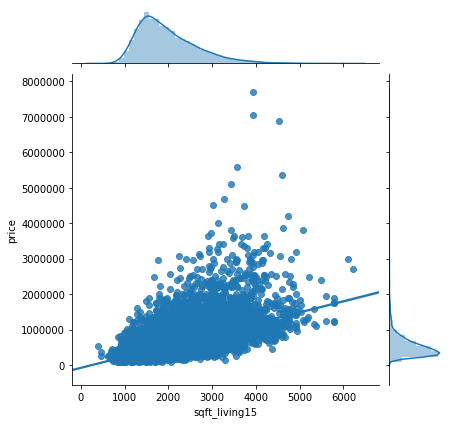

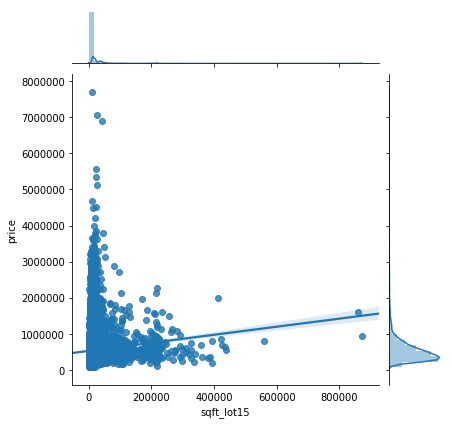

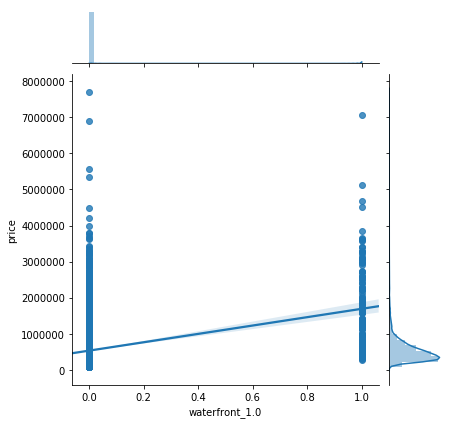

In [20]:
#Using joint plots to check linearity and homoscedasticity
#will check normality of residuals after building model


#plotting selected variables
for col in df_1.drop('price', axis=1):
    sns.jointplot(col,'price',data=df,kind='reg')
    plt.show()

---

## Initial Multiple Linear Regression Model

**Initial model with all variables positively correlated with target ('price')**

In [21]:
#sklearn linear regression
linreg_summary(df_1)

R^2: 0.5969609458330538
MSE: 52100657277.125145
RMSE: 228255.68399740924
MAE: 153361.6993735206
TRAIN_MSE: 52881792569.799225


**Not a big difference between test MSE and train MSE which is good.** <br/>
**A big difference is an indication overfitting.**

/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     2766.
Date:                Mon, 09 Sep 2019   Prob (F-statistic):               0.00
Time:                        15:34:06   Log-Likelihood:            -2.9637e+05
No. Observations:               21534   AIC:                         5.928e+05
Df Residuals:                   21521   BIC:                         5.929e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6.931e+05   1.75e+04    -39.719      0.000   -7.27e+05   -6.59e+05
bedrooms         -3.5e+04   2163.423    -16.177      0.000   -3.92e+04   -3.08e+04
bathrooms      -1.541e+04   3489.367     -4.417      0.000   -2.23e+04   -8574.807
sqft_living      133.4256      2.553     52.267      0.000     128.422     138.429
sqft_lot           0.0269      0.055      0.493      0.622      -0.080       0.134
floors         -2495.0127   3985.668     -0.626      0.531   -1.03e+04    5317.193
view            6.193e+04   2375.952     26.067      0.000    5.73e+04    6.66e+04
condition       5.409e+04   2527.476     21.402      0.000    4.91e+04     5.9e+04
grade           1.016e+05   2371.863     42.828      0.000    9.69e+04    1.06e+05
sqft_above        52.4997      2.508     20.936      0.000      47.585      57.415
sqft_basement     80.9259      2.925     27.668      0.000      75.193      86.659
sqft_living15     10.6305      3.822      2.781      0.005       3.138      18.123
sqft_lot15        -0.7605      0.083     -9.132      0.000      -0.924      -0.597
waterfront_1.0  5.962e+05   2.08e+04     28.726      0.000    5.56e+05    6.37e+05
==============================================================================
Omnibus:                    15565.699   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           924426.282
Skew:                           2.889   Prob(JB):                         0.00
Kurtosis:                      34.574   Cond. No.                     3.37e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.84e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

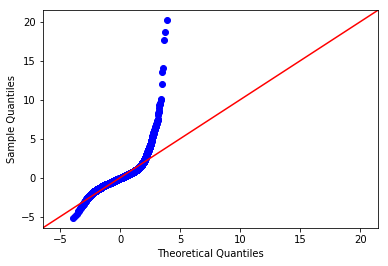

In [22]:
#statsmodels OLS version to see p_values, and show residuals plot
ols_linreg_summary(df_1)

**Looks like there is a deviation, need to look into further**

---

**Next model:**
1. Remove independent variables with p-value above of 0.05 ('sqft_lot' and 'floors')
2. Remove independent variables that are highly correlated with each other

---

## Multicollinearity Check

**Correlation with an absolute value around 0.7-0.8 or higher is considered a high correlation. <br/>
I will remove independant variables that are highly correlated with each other.**

In [23]:
df_1.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,waterfront_1.0
price,1.000000,0.308063,0.525053,0.701587,0.090338,0.257052,0.395734,0.035393,0.668307,0.605695,0.321816,0.585304,0.083189,0.259220
bedrooms,0.308063,1.000000,0.514368,0.577934,0.032735,0.177391,0.078523,0.026402,0.356095,0.479148,0.302149,0.392874,0.030952,-0.003733
bathrooms,0.525053,0.514368,1.000000,0.755277,0.088921,0.502285,0.186451,-0.126682,0.665312,0.686173,0.282563,0.569139,0.088854,0.061115
sqft_living,0.701587,0.577934,0.755277,1.000000,0.173768,0.353529,0.282532,-0.059783,0.762398,0.876553,0.433930,0.756208,0.184801,0.101982
sqft_lot,0.090338,0.032735,0.088921,0.173768,1.000000,-0.005025,0.075298,-0.008375,0.115122,0.184325,0.015487,0.145142,0.717095,0.021465
floors,0.257052,0.177391,0.502285,0.353529,-0.005025,1.000000,0.028436,-0.264138,0.458694,0.523367,-0.246203,0.279176,-0.010850,0.020357
view,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,1.000000,0.045735,0.249727,0.166299,0.274887,0.279561,0.073332,0.382000
condition,0.035393,0.026402,-0.126682,-0.059783,-0.008375,-0.264138,0.045735,1.000000,-0.147326,-0.158830,0.173279,-0.093172,-0.002702,0.016224
grade,0.668307,0.356095,0.665312,0.762398,0.115122,0.458694,0.249727,-0.147326,1.000000,0.755977,0.166673,0.713462,0.121435,0.081195
sqft_above,0.605695,0.479148,0.686173,0.876553,0.184325,0.523367,0.166299,-0.158830,0.755977,1.000000,-0.053268,0.731543,0.195413,0.069931


In [24]:
#check to see which independant variables have corraletion greater than 0.8
abs(df_1.corr()) > 0.8

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,waterfront_1.0
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,False,False,False,False,False,True,False,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,True,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,True,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,True,False,False,False,False,False
sqft_above,False,False,False,True,False,False,False,False,False,True,False,False,False,False


**Independant Variables Highly Correlated with each other** <br/>
sqft_living - sqft_above <br/>
sqft_above - sqft_living <br/>

**I will drop ONLY 'sqft_above' because 'sqft_living' is has a higher correlation to the target variable.**

---

## Second Multiple Linear Regression Model

In [25]:
#Create new df for second model
df_2 = df_1.drop(df_1[['sqft_lot', 'floors', 'sqft_above']], axis=1)

In [26]:
linreg_summary(df_2)

R^2: 0.5970702477152003
MSE: 52086527877.39927
RMSE: 228224.7310818862
MAE: 153237.50538378596
TRAIN_MSE: 52885824056.71533


---

**Next model:**
1. Try log-transformations 
2. Min-max scale variables with high magnitudes
3. Create dummy variables for columns with few value counts
4. Decide how to deal with outliers

---

## Log Transformation

In [ ]:
df_2.columns

In [ ]:
df_log = pd.DataFrame([])
df_log['bathrooms'] = np.log(df_2['bathrooms'])
df_log['bedrooms'] = np.log(df_2['bedrooms'])
df_log['sqft_living'] = np.log(df_2['sqft_living'])
df_log['sqft_living15'] = np.log(df_2['sqft_living15'])
df_log['sqft_lot15'] = np.log(df_2['sqft_lot15'])
df_log['price'] = np.log(df_2['price'])

#
df_log['grade'] = df_2['grade']
df_log['waterfront_1'] = df_2['waterfront_1.0']
df_log['sqft_basement'] = df_2['sqft_basement']
df_log['view'] = df_2['view']


In [ ]:
df_log.hist(figsize=(15,15));

In [ ]:
linreg_summary(df_log)